# The Big3Project

The men's tennis circuit in the 21st century has been dominated by just three men. Roger Federer, Rafael Nadal and Novak Djokovic, in order of appearence, have imposed their law, killed new generations and monopolized trophies from the main tournaments. However, one big question is still passionately discussed among the tennis fans, "Who is the best of them?".

With this project, my only humble purpose is not to categorically answer that question, but to use the data we have at our disposition to try to help the fans to objectively decide for themselves who has been the GOAT. 

Finally, let this serve as a disclaimer, at the moment of this project (August 2021) the three players are still active, so I know that this analysis will be outdated sooner than later. I still hope this helps to understand this rivalry, acknowledge the amazing records each of them has achieved and realize that without this fierce competition on the court, probably none of them would have become the players they are.

In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta

# Data reading

We start by reading the files we have from the JeffSackmann GitHub repository (https://github.com/JeffSackmann/tennis_atp). Special thanks to Jeff for his amazing work collecting all this data. 


### Matches

These include futures (atp_matches_futures_1991.csv), challengers (atp_matches_qual_chall_yyyy) and atp tournaments (atp_matches_yyyy). For the purpose of this project we will only use the ATP matches from ATP 250 tournaments and above. There are several matches files, separated by seasons (years). We will iterate through our directory and concatenate all of them to obtain a single dataset.

In [29]:


%cd "C:\Users\josea\Big3Project\matches"

path = %pwd
filesnames = os.listdir(path)
filesnames = [f for f in filesnames] 

dfs = [] # Empty list to append the df later
matches = pd.DataFrame() # Names of the columns

for filename in filesnames:
    df = pd.read_csv(filename)
    dfs.append(df)
    matches = pd.concat(dfs) # The datframes are concatenated from the dfs list to obtain a single df (matches)
    
matches.reset_index(inplace = True, drop = True) # The index is reset, as each datframe from dfs has its own numeric index
matches.head()


C:\Users\josea\Big3Project\matches


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1998-339,Adelaide,Hard,32,A,19980105,1,102035,1.0,NaN,...,29.0,18.0,11.0,9.0,2.0,5.0,4.0,2949.0,74.0,649.0
1,1998-339,Adelaide,Hard,32,A,19980105,2,101727,NaN,NaN,...,32.0,19.0,11.0,8.0,9.0,13.0,79.0,617.0,87.0,537.0
2,1998-339,Adelaide,Hard,32,A,19980105,3,102765,NaN,Q,...,38.0,18.0,7.0,9.0,5.0,12.0,93.0,521.0,71.0,665.0
3,1998-339,Adelaide,Hard,32,A,19980105,4,102563,7.0,NaN,...,37.0,21.0,10.0,11.0,1.0,6.0,39.0,959.0,76.0,633.0
4,1998-339,Adelaide,Hard,32,A,19980105,5,102796,4.0,NaN,...,57.0,33.0,20.0,13.0,12.0,17.0,22.0,1450.0,65.0,708.0


### Players

In this case we just have a single file which includes all the players with a unique id, along with basic data (name, surname, dominant hand, country). 

In [30]:
%cd "C:\Users\josea\Big3Project\players"

players = pd.read_csv("atp_players.csv", header= None)

players.columns = ["player_id", "first_name", "last_name", "dominant_hand", "birth_date", "country"]
players.head()


C:\Users\josea\Big3Project\players


,player_id,first_name,last_name,dominant_hand,birth_date,country
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA


### Ranking

Dataset with files for every decade which gather the ranking. As we have one file per decade, the strategy is the same as for the matches dataset, with a loop to get all of them to concatenate them later.

In [31]:
%cd "C:\Users\josea\Big3Project\ranking"

path = %pwd
ranking_filesnames = os.listdir(path)
ranking_filesnames = [f for f in ranking_filesnames] 

ranking_dfs = []
ranking = pd.DataFrame()

for ranking_filename in ranking_filesnames:
    ranking_df = pd.read_csv(ranking_filename)
    ranking_dfs.append(ranking_df)
    ranking = pd.concat(ranking_dfs)

ranking.reset_index(inplace = True, drop = True)

ranking.columns = ['ranking_date', 'ranking', 'player_id', 'points']


ranking.sort_values(by=['ranking_date'], inplace=True)

ranking.head()


C:\Users\josea\Big3Project\ranking


,ranking_date,ranking,player_id,points
1890161,19900101,480,101961,24.0
1890538,19900101,859,101176,5.0
1890537,19900101,854,108426,5.0
1890536,19900101,854,107680,5.0
1890535,19900101,854,107643,5.0


# Data Cleaning

We will only keep the rows involving Federer, Nadal and Djokovic. So we need to create subsets from the matches datframe where these players were wether the winner or the loser. 

In [32]:
# The columns are  ['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
#                   'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_seed', 'winner_entry',
#                   'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
#                   'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
#                   'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
#                   'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
#                   'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
#                   'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
#                   'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points']

# But we do not need all those, we just need for our analysis a few of them

columns = ['tourney_name', 'tourney_date', 'tourney_level', 'surface', 'draw_size',  'winner_name', 'winner_age', 
'winner_ioc',  'loser_name', 'loser_ioc', 'loser_age', 'best_of', 'round', 'minutes', 'winner_rank', 'loser_rank', 'score']

matches = matches[columns]
matches.tourney_date = pd.to_datetime(matches.tourney_date, format='%Y%m%d').dt.strftime('%Y') # We format the date from the tournament date column, as it is given as an integer yyyymmdd. Then, we are only interested in the year
## We wont take into account the Davis cup matches for our analysis because they involve a whole team
matches = matches[matches.tourney_level != "D"]
# matches.tourney_name.unique()
## We have entries named with both Us Open and US Open, lets unify those. Besides the ATP Finals were formerly known as Masters Cup, we will unify those too
matches.tourney_name[matches.tourney_name=="Us Open"] = "US Open"
matches.tourney_name[matches.tourney_name=="Masters Cup"] = "Masters Cup/Tour Finals"
matches.tourney_name[matches.tourney_name=="Tour Finals"] = "Masters Cup/Tour Finals"

############################################################################################################
# ALL MATCHES
############################################################################################################

Big3Matches = matches[(matches["winner_name"] == "Roger Federer") | (matches["loser_name"] == "Roger Federer") | 
                      (matches["winner_name"] == "Rafael Nadal") | (matches["loser_name"] == "Rafael Nadal") | 
                      (matches["winner_name"] == "Novak Djokovic") | (matches["loser_name"] == "Novak Djokovic")]

### We create sub dfs from the matches dataframe for each one of the Big three players
Federer_matches = matches[(matches["winner_name"] == "Roger Federer") | (matches["loser_name"] == "Roger Federer")]
Nadal_matches = matches[(matches["winner_name"] == "Rafael Nadal") | (matches["loser_name"] == "Rafael Nadal")]
Djokovic_matches = matches[(matches["winner_name"] == "Novak Djokovic") | (matches["loser_name"] == "Novak Djokovic")]

### The round is "F" no matter if the winner is one of the big three or not, so I will substitute the "F" with a "W" on those rows where 
### one of the big three were the winners, but we need to do it separately because there are Finlas where they have faced each other,
### so this solumn is relative to each one
Federer_matches.loc[(Federer_matches["round"] == "F") & (Federer_matches["winner_name"] == "Roger Federer"), "round"] = "W" 
Nadal_matches.loc[(Nadal_matches["round"] == "F") & (Nadal_matches["winner_name"] == "Rafael Nadal"), "round"] = "W" 
Djokovic_matches.loc[(Djokovic_matches["round"] == "F") & (Djokovic_matches["winner_name"] == "Novak Djokovic"), "round"] = "W" 






### COMMENT HERE THAT THE FOLLOWING IS NOT NECESSARY AS TABLEAU ALREAD DOES IT VERY EASILY

############################################################################################################
# GS MATCHES
############################################################################################################

# Federer GS matches
Federer_GS_matches = Federer_matches[Federer_matches["tourney_level"] == "G"]
Federer_sep_gs_matches = {gs: Federer_GS_matches[Federer_GS_matches["tourney_name"] == gs] 
                          for gs in Federer_GS_matches.tourney_name.unique()}

for key in Federer_sep_gs_matches.keys():
    Federer_sep_gs_matches[key] = Federer_GS_matches[:][Federer_GS_matches.tourney_name == key]

# Nadal GS matches
Nadal_GS_matches = Nadal_matches[Nadal_matches["tourney_level"] == "G"]
Nadal_sep_gs_matches = {gs: Nadal_GS_matches[Nadal_GS_matches["tourney_name"] == gs] 
                          for gs in Nadal_GS_matches.tourney_name.unique()}

for key in Nadal_sep_gs_matches.keys():
    Nadal_sep_gs_matches[key] = Nadal_GS_matches[:][Nadal_GS_matches.tourney_name == key]


# Djokovic GS matches
Djokovic_GS_matches = Djokovic_matches[Djokovic_matches["tourney_level"] == "G"]
Djokovic_sep_gs_matches = {gs: Djokovic_GS_matches[Djokovic_GS_matches["tourney_name"] == gs] 
                          for gs in Djokovic_GS_matches.tourney_name.unique()}

for key in Djokovic_sep_gs_matches.keys():
    Djokovic_sep_gs_matches[key] = Djokovic_GS_matches[:][Djokovic_GS_matches.tourney_name == key]
    
## A different option, less technical where we need to hardcode using the GS names:
# Federer_GS_matches.unique(), Nadal_GS_matches.unique(), Djokovic_GS_matches.unique()
Federer_GS_matches_AO = Federer_GS_matches[Federer_GS_matches["tourney_name"] == "Australian Open"]
Federer_GS_matches_RG = Federer_GS_matches[Federer_GS_matches["tourney_name"] == "Roland Garros"]
Federer_GS_matches_W = Federer_GS_matches[Federer_GS_matches["tourney_name"] == "Wimbledon"]
Federer_GS_matches_UO = Federer_GS_matches[Federer_GS_matches["tourney_name"] == "US Open"]

Nadal_GS_matches_AO = Nadal_GS_matches[Nadal_GS_matches["tourney_name"] == "Australian Open"]
Nadal_GS_matches_RG = Nadal_GS_matches[Nadal_GS_matches["tourney_name"] == "Roland Garros"]
Nadal_GS_matches_W = Nadal_GS_matches[Nadal_GS_matches["tourney_name"] == "Wimbledon"]
Nadal_GS_matches_UO = Nadal_GS_matches[Nadal_GS_matches["tourney_name"] == "US Open"]

Djokovic_GS_matches_AO = Djokovic_GS_matches[Djokovic_GS_matches["tourney_name"] == "Australian Open"]
Djokovic_GS_matches_RG = Djokovic_GS_matches[Djokovic_GS_matches["tourney_name"] == "Roland Garros"]
Djokovic_GS_matches_W = Djokovic_GS_matches[Djokovic_GS_matches["tourney_name"] == "Wimbledon"]
Djokovic_GS_matches_UO = Djokovic_GS_matches[Djokovic_GS_matches["tourney_name"] == "US Open"]

############################################################################################################
# M1000 MATCHES
############################################################################################################

Federer_M1000_matches = Federer_matches[Federer_matches["tourney_level"] == "M"]
Nadal_M1000_matches = Nadal_matches[Nadal_matches["tourney_level"] == "M"]
Djokovic_M1000_matches = Djokovic_matches[Djokovic_matches["tourney_level"] == "M"]   

# Federer M1000 matches
Federer_M1000_matches = Federer_matches[Federer_matches["tourney_level"] == "M"]
Federer_sep_m1000_matches = {mt: Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == mt] 
                          for mt in Federer_M1000_matches.tourney_name.unique()}

for key in Federer_sep_m1000_matches.keys():
    Federer_sep_m1000_matches[key] = Federer_M1000_matches[:][Federer_M1000_matches.tourney_name == key]

# Nadal M1000 matches
Nadal_M1000_matches = Nadal_matches[Nadal_matches["tourney_level"] == "M"]
Nadal_sep_m1000_matches = {mt: Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == mt] 
                          for mt in Nadal_M1000_matches.tourney_name.unique()}

for key in Nadal_sep_m1000_matches.keys():
    Nadal_sep_m1000_matches[key] = Nadal_M1000_matches[:][Nadal_M1000_matches.tourney_name == key]

# Djokovic M1000 matches
Djokovic_M1000_matches = Djokovic_matches[Djokovic_matches["tourney_level"] == "M"]
Djokovic_sep_m1000_matches = {mt: Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == mt] 
                          for mt in Djokovic_M1000_matches.tourney_name.unique()}

for key in Djokovic_sep_m1000_matches.keys():
    Djokovic_sep_m1000_matches[key] = Djokovic_M1000_matches[:][Djokovic_M1000_matches.tourney_name == key]

# A different option, less technical where we need to hardcode using the M1000 names:
# Federer_M1000_matches.unique(), Nadal_M1000_matches.unique(), Djokovic_M1000_matches.unique()
# When Federer started playing there was a M1000 in Stuttgart, being succeeded by Madrid Open in 2002.
# Hamburg was a clay M1000 til 2009, when it was succeeded by Madrid, changing this last one from hard to clay.
# Shanghai was introduced as a M1000 in 2009 and it is played on hard surface
Federer_M1000_matches_Miami = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Miami Masters"]
Federer_M1000_matches_MonteCarlo = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Monte Carlo Masters"]
Federer_M1000_matches_Paris = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Paris Masters"]
Federer_M1000_matches_Stuttgart = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Stuttgart Masters"]
Federer_M1000_matches_Hamburg = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Hamburg Masters"]
Federer_M1000_matches_Rome = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Rome Masters"]
Federer_M1000_matches_Canada = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Canada Masters"]
Federer_M1000_matches_Cincinatti = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Cincinnati Masters"]
Federer_M1000_matches_IndianWells = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Indian Wells Masters"]
Federer_M1000_matches_Madrid = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Madrid Masters"]
Federer_M1000_matches_Shanghai = Federer_M1000_matches[Federer_M1000_matches["tourney_name"] == "Shanghai Masters"]

Nadal_M1000_matches_Miami = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Miami Masters"]
Nadal_M1000_matches_MonteCarlo = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Monte Carlo Masters"]
Nadal_M1000_matches_Paris = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Paris Masters"]
Nadal_M1000_matches_Hamburg = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Hamburg Masters"]
Nadal_M1000_matches_Rome = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Rome Masters"]
Nadal_M1000_matches_Canada = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Canada Masters"]
Nadal_M1000_matches_Cincinatti = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Cincinnati Masters"]
Nadal_M1000_matches_IndianWells = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Indian Wells Masters"]
Nadal_M1000_matches_Madrid = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Madrid Masters"]
Nadal_M1000_matches_Shanghai = Nadal_M1000_matches[Nadal_M1000_matches["tourney_name"] == "Shanghai Masters"]

Djokovic_M1000_matches_Miami = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Miami Masters"]
Djokovic_M1000_matches_MonteCarlo = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Monte Carlo Masters"]
Djokovic_M1000_matches_Paris = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Paris Masters"]
Djokovic_M1000_matches_Hamburg = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Hamburg Masters"]
Djokovic_M1000_matches_Rome = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Rome Masters"]
Djokovic_M1000_matches_Canada = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Canada Masters"]
Djokovic_M1000_matches_Cincinatti = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Cincinnati Masters"]
Djokovic_M1000_matches_IndianWells = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Indian Wells Masters"]
Djokovic_M1000_matches_Madrid = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Madrid Masters"]
Djokovic_M1000_matches_Shanghai = Djokovic_M1000_matches[Djokovic_M1000_matches["tourney_name"] == "Shanghai Masters"]


C:\Users\josea\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\josea\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\josea\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [33]:
ranking.ranking_date = pd.to_datetime(ranking.ranking_date, format='%Y%m%d') # We format the date from the ranking date column, as it is given as an integer yyyymmdd

# In the ranking we just have the player id, we need to merge with the players datframe
rank_players = ranking.merge(players, on = 'player_id')
rank_players.sort_values('ranking_date', inplace= True)

Federer_ranking = rank_players[rank_players["last_name"] == "Federer"]
Nadal_ranking = rank_players[rank_players["last_name"] == "Nadal"]
Djokovic_ranking = rank_players[(rank_players["first_name"] == "Novak") & (rank_players["last_name"] == "Djokovic")]


# Stats and records




In [34]:
# Number of ATP titles
len(Federer_matches[Federer_matches["round"] == "W"]), len(Nadal_matches[Nadal_matches["round"] == "W"]), len(Djokovic_matches[Djokovic_matches["round"] == "W"])

# Number of GS titles and of M1000

len(Federer_GS_matches[Federer_GS_matches["round"] == "W"]), len(Nadal_GS_matches[Nadal_GS_matches["round"] == "W"]), len(Djokovic_GS_matches[Djokovic_GS_matches["round"] == "W"])
len(Federer_M1000_matches[Federer_M1000_matches["round"] == "W"]), len(Nadal_M1000_matches[Nadal_M1000_matches["round"] == "W"]), len(Djokovic_M1000_matches[Djokovic_M1000_matches["round"] == "W"])



(28, 36, 36)

In [35]:
# Weeks as number 1 in the ranking

Federer_weeks1 = len(Federer_ranking[Federer_ranking["ranking"] == 1].index)
Nadal_weeks1 = len(Nadal_ranking[Nadal_ranking["ranking"] == 1].index)
Djokovic_weeks1 = len(Djokovic_ranking[Djokovic_ranking["ranking"] == 1].index)

Federer_weeks1, Nadal_weeks1, Djokovic_weeks1

(307, 193, 294)

Just as a side note, the ranking was frozen between 2020-03-16 and 2020-08-24 due to the Covid-19 pandemy. 

Besides, a lot of missing weeks were found in the ranking dataset. These gaps can even be seen in the ATP raking webpage itself 
(https://www.atptour.com/es/rankings/singles) and these missing weeks affect the number of weeks as rank 1 for the Big 3.
For example, with our current ranking csv, we get that Nadal was 193 weeks number, while the official figure is 209.
This also affects Nole and Federer figures, with 307 and 283 with the current counting, while the actual figures are 331 and 318 respectively.
I want to fix this.



(310, 209, 331)

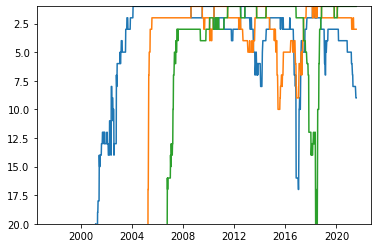

In [36]:
# We will try to find the missing weeks, getting those rows from the ranking_date column where 
# the difference of days is greater than 7 days. Then we will get which player was number 1 the previous 
# week to that missing week and append it to an empty list:

missing_weeks_players = []
for d in range(0, len(rank_players.ranking_date.unique())-1):
    if ( (rank_players.ranking_date.unique()[d+1] - rank_players.ranking_date.unique()[d]).astype('timedelta64[D]')/ np.timedelta64(1, 'D')) > 7.0:
        missing_weeks_players.append(rank_players.last_name[(rank_players.ranking == 1) & (rank_players.ranking_date == rank_players.ranking_date.unique()[d])].iloc[0])


# If we sum up the missing weeks to our previous numbers:
Federer_weeks1 = Federer_weeks1 + missing_weeks_players.count("Federer")
Nadal_weeks1 = Nadal_weeks1 + missing_weeks_players.count("Nadal")
Djokovic_weeks1 = Djokovic_weeks1 + missing_weeks_players.count("Djokovic")

# Then we get the correct figures:

Federer_weeks1, Nadal_weeks1, Djokovic_weeks1

# Now let´s plot the ranking of the Big 3 along time
plt.plot(Federer_ranking.ranking_date,Federer_ranking.ranking)
plt.plot(Nadal_ranking.ranking_date,Nadal_ranking.ranking)
plt.plot(Djokovic_ranking.ranking_date,Djokovic_ranking.ranking)
plt.gca().set_ylim([1,20])
plt.gca().invert_yaxis()


Federer_weeks1, Nadal_weeks1, Djokovic_weeks1

The previous cell of code was just a way of checking that the missing dates in the ranking dataset added up to the correct figures. We will solve this gaps in the dataset via SQL in a different partt of the project before starting the final part of the project, the data visualization in Tableau.

# Exporting data to use in Tableau

In [37]:
Big3Matches.to_excel(r'C:\Users\josea\Big3Project\Big3Matches.xlsx')

Federer_matches.to_excel(r'C:\Users\josea\Big3Project\Federer matches.xlsx')
Nadal_matches.to_excel(r'C:\Users\josea\Big3Project\Nadal matches.xlsx')
Djokovic_matches.to_excel(r'C:\Users\josea\Big3Project\Djokovic matches.xlsx')
